✅ OBJECTIVE 1: Predict Ad Trends (Revenue Prediction)


In [1]:
# Install required libraries
!pip install pandas scikit-learn tensorflow keras matplotlib seaborn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense


In [2]:
# Load train.csv and flatten JSON columns
def load_and_flatten(filepath):
    df = pd.read_csv(filepath,
                     converters={
                         'device': json.loads,
                         'geoNetwork': json.loads,
                         'totals': json.loads,
                         'trafficSource': json.loads
                     },
                     dtype={'fullVisitorId': 'str'})
    return df

df = load_and_flatten('/content/train.csv')
print("Initial shape:", df.shape)
df.head()


Initial shape: (903653, 12)


,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386
3,Organic Search,20160902,"{'browser': 'UC Browser', 'browserVersion': 'n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472881213,1,1472881213
4,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472822600,2,1472822600


In [3]:
# Flatten nested columns using json_normalize
device_df = pd.json_normalize(df['device'])
geo_df = pd.json_normalize(df['geoNetwork'])
totals_df = pd.json_normalize(df['totals'])
traffic_df = pd.json_normalize(df['trafficSource'])

# Concatenate flattened fields into main DataFrame
df = pd.concat([df.drop(columns=['device', 'geoNetwork', 'totals', 'trafficSource']),
                device_df, geo_df, totals_df, traffic_df], axis=1)

# Convert revenue to numeric (fill missing with 0 and scale it)
df['transactionRevenue'] = pd.to_numeric(df['transactionRevenue'], errors='coerce').fillna(0)
df['transactionRevenue'] = df['transactionRevenue'] / 1e6  # Convert to millions for readability


In [4]:
# Encode selected categorical fields into numbers
df['isMobile'] = df['isMobile'].astype(int)
df['deviceCategory'] = df['deviceCategory'].astype('category').cat.codes
df['country'] = df['country'].astype('category').cat.codes
df['source'] = df['source'].astype('category').cat.codes
df['visitNumber'] = df['visitNumber'].astype(int)

# Define features and target
features = df[['isMobile', 'deviceCategory', 'country', 'source', 'visitNumber']]
target = df['transactionRevenue']

# Check basic stats
print("Revenue values summary:")
print(target.describe())


Revenue values summary:
count    903653.000000
mean          1.704273
std          52.778659
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       23129.500000
Name: transactionRevenue, dtype: float64


In [5]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
preds_lr = lr.predict(X_test)

# Model evaluation
from sklearn.metrics import mean_squared_error, r2_score

print("📉 Linear Regression MSE:", mean_squared_error(y_test, preds_lr))
print("📈 Linear Regression R^2 Score:", r2_score(y_test, preds_lr))


📉 Linear Regression MSE: 2980.297018107896
📈 Linear Regression R^2 Score: 0.0034582075389484324


In [6]:
# Build and train a simple neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Output layer for regression

nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 1789.2224 - val_loss: 5648.8960
Epoch 2/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 2102.1147 - val_loss: 5654.9810
Epoch 3/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 1297.4663 - val_loss: 5694.0039
Epoch 4/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - loss: 2044.1462 - val_loss: 5635.9048
Epoch 5/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 1584.7253 - val_loss: 5651.2085
Epoch 6/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 2344.9216 - val_loss: 5647.0273
Epoch 7/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 1623.7732 - val_loss: 5599.4380
Epoch 8/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 1811.4897 - val_loss: 5640.5229
Epoch 9/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 1616.9418 - val_loss: 5634.0420
Epoch 10/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 2167.9866 - val_loss: 5629.5850


In [7]:
# Add predictions to DataFrame and save for Tableau
df['predicted_revenue'] = lr.predict(features)
df_export = df[['fullVisitorId', 'deviceCategory', 'country', 'source', 'visitNumber', 'transactionRevenue', 'predicted_revenue']]
df_export.to_csv('/content/predicted_revenue.csv', index=False)
print("✅ Exported to /content/predicted_revenue.csv")


✅ Exported to /content/predicted_revenue.csv


🎯 Objective 2: Spot Customer Patterns Using Neural Networks

In [8]:
# Add new binary target: made_purchase (1 if revenue > 0)
df['made_purchase'] = df['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
print(df['made_purchase'].value_counts())

made_purchase
0    892138
1     11515
Name: count, dtype: int64


In [9]:
# Define features and binary target
X = df[['isMobile', 'deviceCategory', 'country', 'source', 'visitNumber']]
y = df['made_purchase']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Build binary classifier model
clf = Sequential()
clf.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
clf.add(Dense(32, activation='relu'))
clf.add(Dense(1, activation='sigmoid'))  # sigmoid for binary classification

# Compile and train
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
clf.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9863 - loss: 0.0867 - val_accuracy: 0.9872 - val_loss: 0.0601
Epoch 2/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9873 - loss: 0.0593 - val_accuracy: 0.9872 - val_loss: 0.0587
Epoch 3/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.9873 - loss: 0.0582 - val_accuracy: 0.9872 - val_loss: 0.0562
Epoch 4/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9872 - loss: 0.0576 - val_accuracy: 0.9872 - val_loss: 0.0581
Epoch 5/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9871 - loss: 0.0574 - val_accuracy: 0.9872 - val_loss: 0.0570
Epoch 6/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9871 - loss: 0.0575 - val_accuracy: 0.9872 - val_loss: 0.0559
Epoch 7/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9873 - loss: 0.0566 - val_accuracy: 0.9872 - val_loss: 0.0560
Epoch 8/10
18074/18074 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 

In [13]:
# Evaluate on test data
loss, accuracy = clf.evaluate(X_test, y_test)
print("✅ Test Accuracy:", accuracy)


5648/5648 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9873 - loss: 0.0568
✅ Test Accuracy: 0.9872573018074036


In [14]:
# Add prediction probabilities and binary output
df['purchase_prob'] = clf.predict(X)
df['purchase_pred'] = (df['purchase_prob'] > 0.5).astype(int)

# Export for Tableau if needed
df[['fullVisitorId', 'isMobile', 'deviceCategory', 'country', 'source', 'visitNumber', 'made_purchase', 'purchase_prob', 'purchase_pred']].to_csv('/content/purchase_predictions.csv', index=False)
print("📤 Exported to /content/purchase_predictions.csv")


28240/28240 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step
📤 Exported to /content/purchase_predictions.csv


Objective 3: Audience Segmentation Using K-Means Clustering


In [15]:
# We’ll reuse the same df DataFrame (from earlier steps)

# Select clustering features (feel free to experiment with more)
cluster_df = df[['isMobile', 'deviceCategory', 'country', 'source', 'visitNumber', 'transactionRevenue']].copy()

# Normalize the data (important for K-Means)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

print("✅ Data normalized and ready for clustering")

✅ Data normalized and ready for clustering


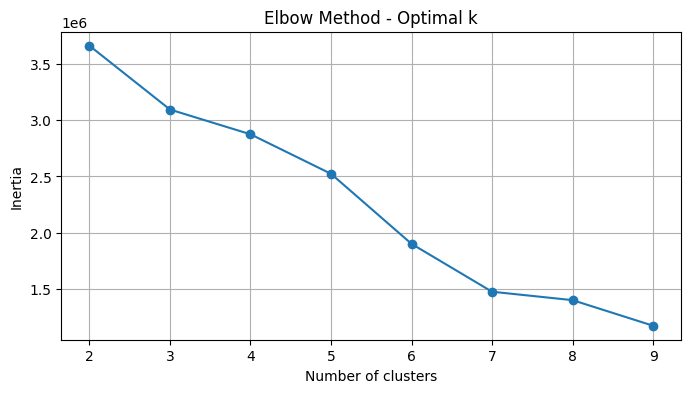

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(cluster_scaled)
    inertia.append(km.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [17]:
# Let’s say you pick k=4 based on the elbow plot
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_scaled)

# See distribution of segments
print(df['cluster'].value_counts())


cluster
0    316766
1    239092
3    233000
2    114795
Name: count, dtype: int64


In [18]:
# Export key fields with cluster labels
df_export_clustered = df[['fullVisitorId', 'isMobile', 'deviceCategory', 'country', 'source', 'visitNumber', 'transactionRevenue', 'cluster']]
df_export_clustered.to_csv('/content/segmented_users.csv', index=False)
print("📤 Exported segmented data to /content/segmented_users.csv")


📤 Exported segmented data to /content/segmented_users.csv
